# Median Filter on Pose Data

The really nice feature of a median filter is that during motion, the true value will likely be chosen. Compare this to a mean filter, where some average of the filtered values will be taken. But, when and outlier occurs, that is far from the other values in the window, it is unlikely to be accepted. The risk is that at points where the motion changes direction (peaks in position curve) that the end of the curve will be cut off. Luckily, these are places where there will be many points stacked up as velocity changes sign and so no data is lost. 

There is some conflict on how big to make the filter. The bigger it is, the better outliers are rejected. The smaller it is, more precisely it captures the data. We are going with a 5 element kernel. This is good enough to reject the single frame outliers that are most prevelant in pose tracking without compromising the data. 

Before performing the median filter, we are careful to remove any superfolous values. We filter on two conditions:

1. The values in x and y are not both zero (0,0 was stored to indicate that the joint could not be found)
2. The confidences (for hands, that is the hand side confidence, for body that is the joint confidence) is greater than 0.15

## Setup

This was run locally

In [99]:
%%capture
!pip install h5py
!pip install filterpy
!pip install pykalman

In [100]:
import h5py
import numpy as np
import filterpy
import filterpy
from matplotlib import pyplot as plt
import pykalman
from scipy import signal
%matplotlib inline 

In [101]:
def plot_filter_out(times, Zs, xs, title):
    ms=1
    plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
    plt.subplot(211)
    plt.tight_layout(pad=3)
    plt.plot(times, Zs[:, 0],'o', label="raw (conf>.15 & !(x=0&y=0))", color='red', markersize=2*ms)
    plt.plot(times,xs[:, 0],'.', label='smoothed', color='blue', markersize=ms)
    plt.title(f'{title} - x')
    plt.subplot(212)
    plt.plot(times, Zs[:, 1],'o', label="raw (conf>.15; not x=0&y=0)",color='red', markersize=2*ms)
    plt.plot(times,xs[:, 1],'.', label='smoothed', color='blue', markersize=ms)
    plt.legend(bbox_to_anchor=(1.01,0.5), loc="center left")
    plt.title(f'{title} - y')

## Target Touch

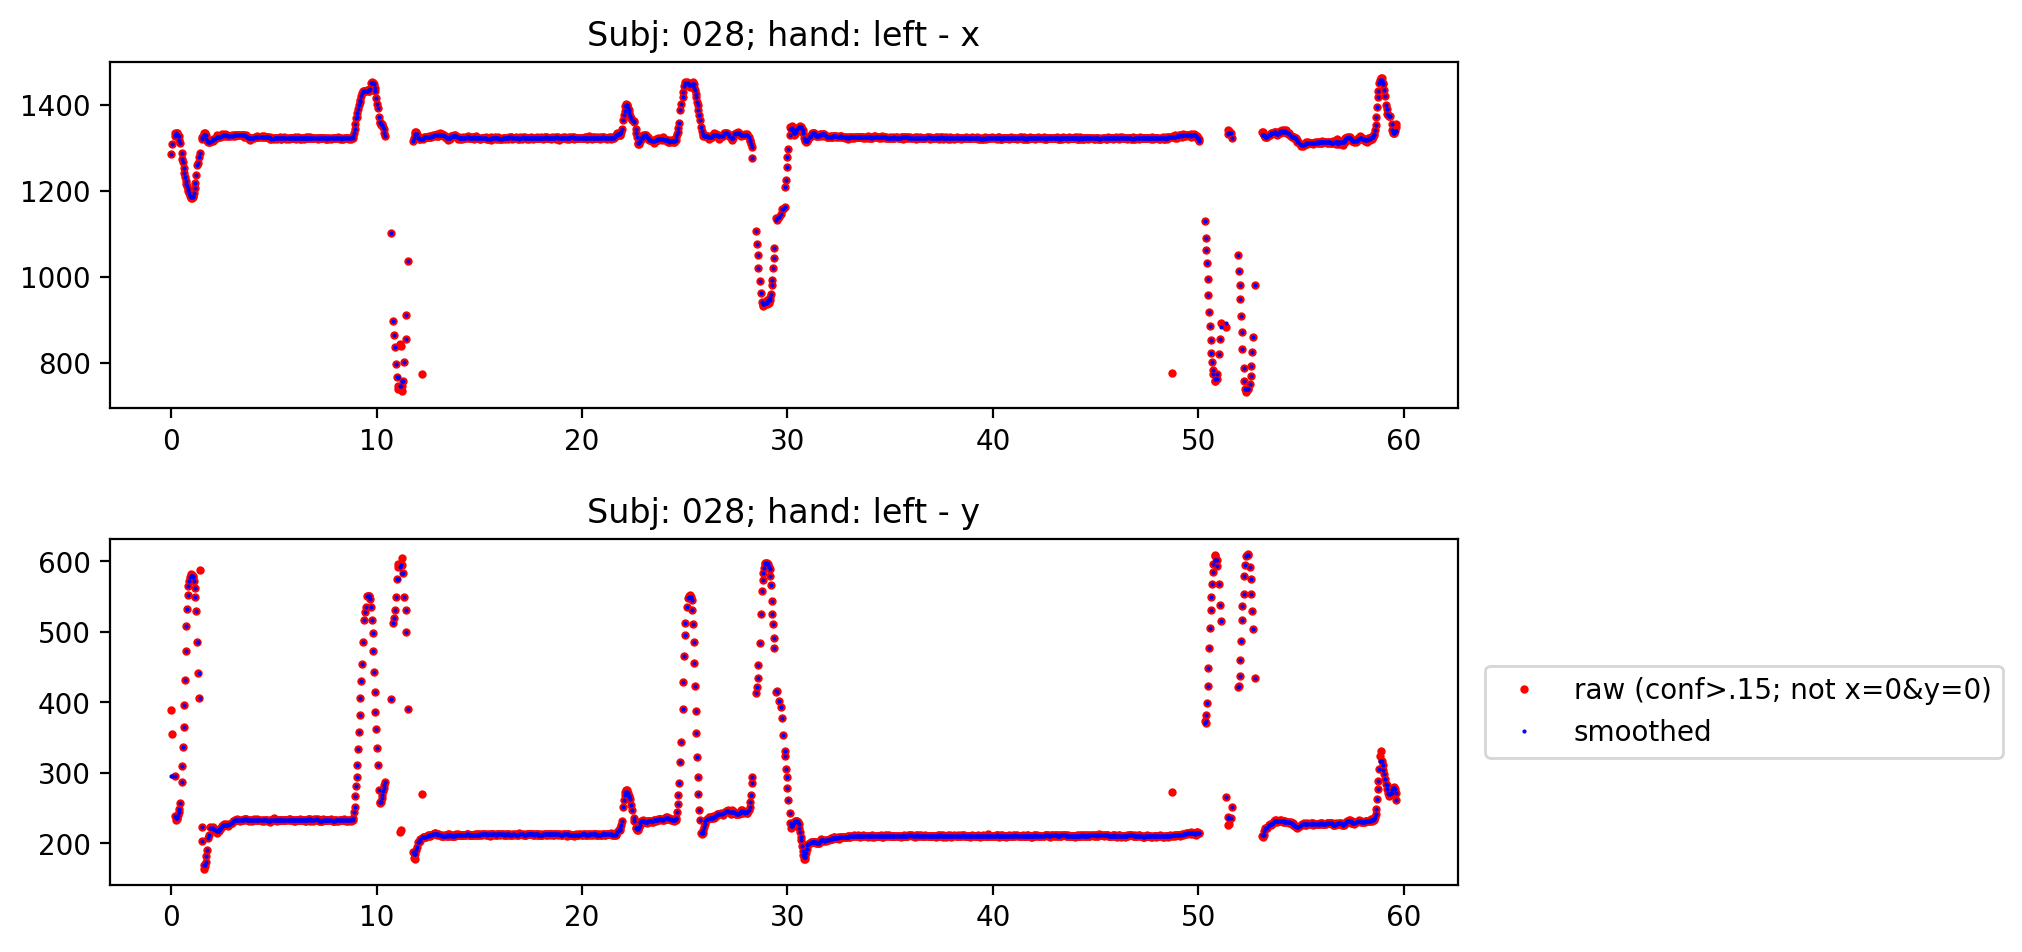

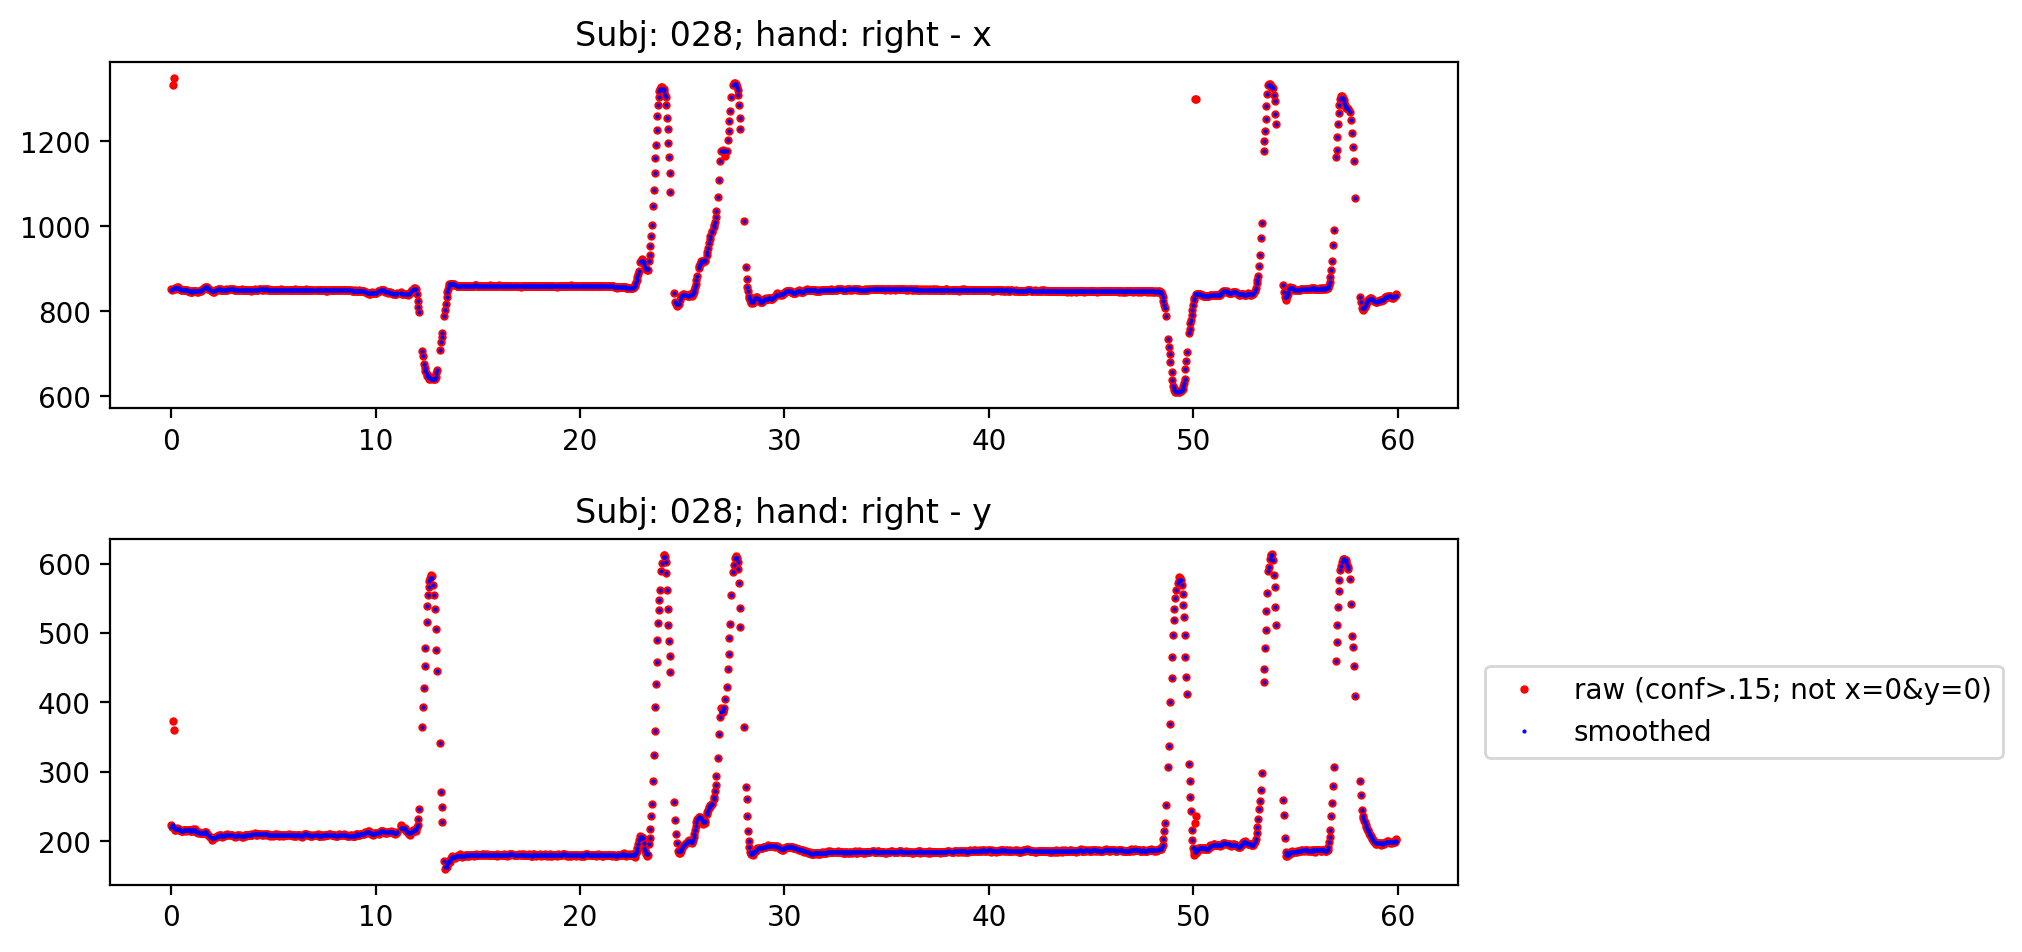

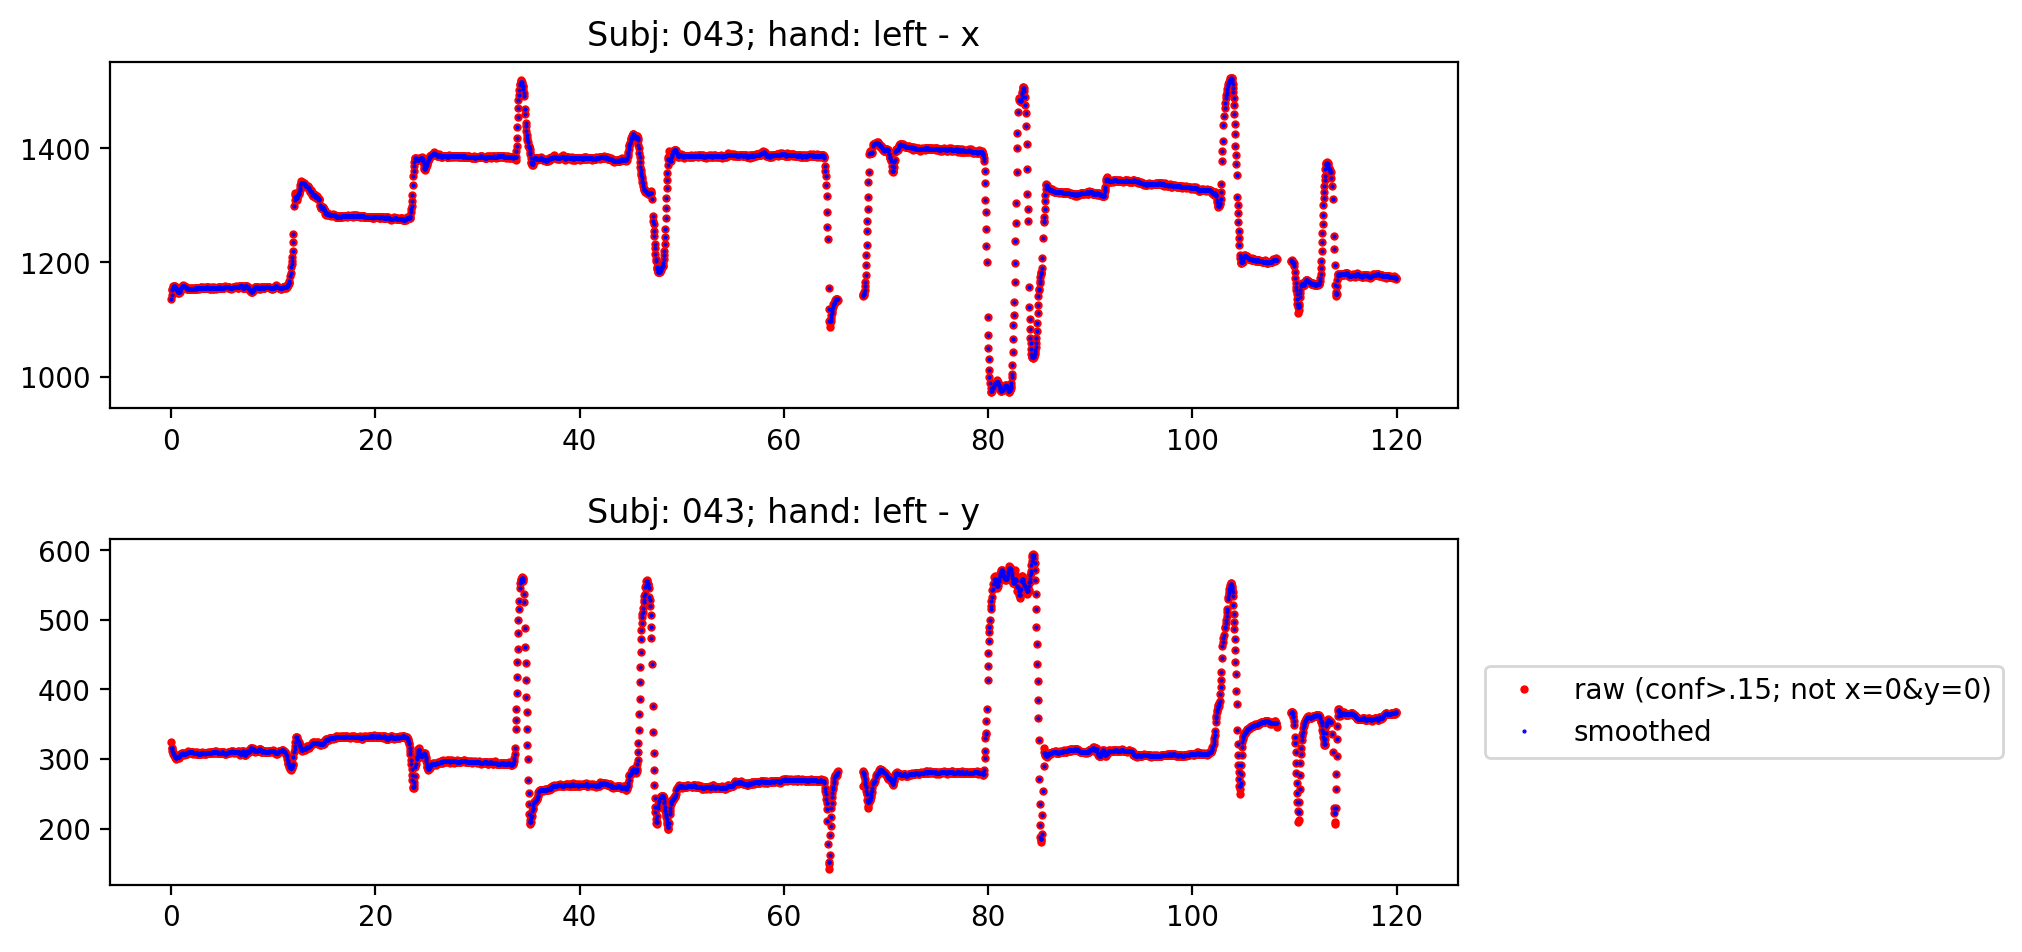

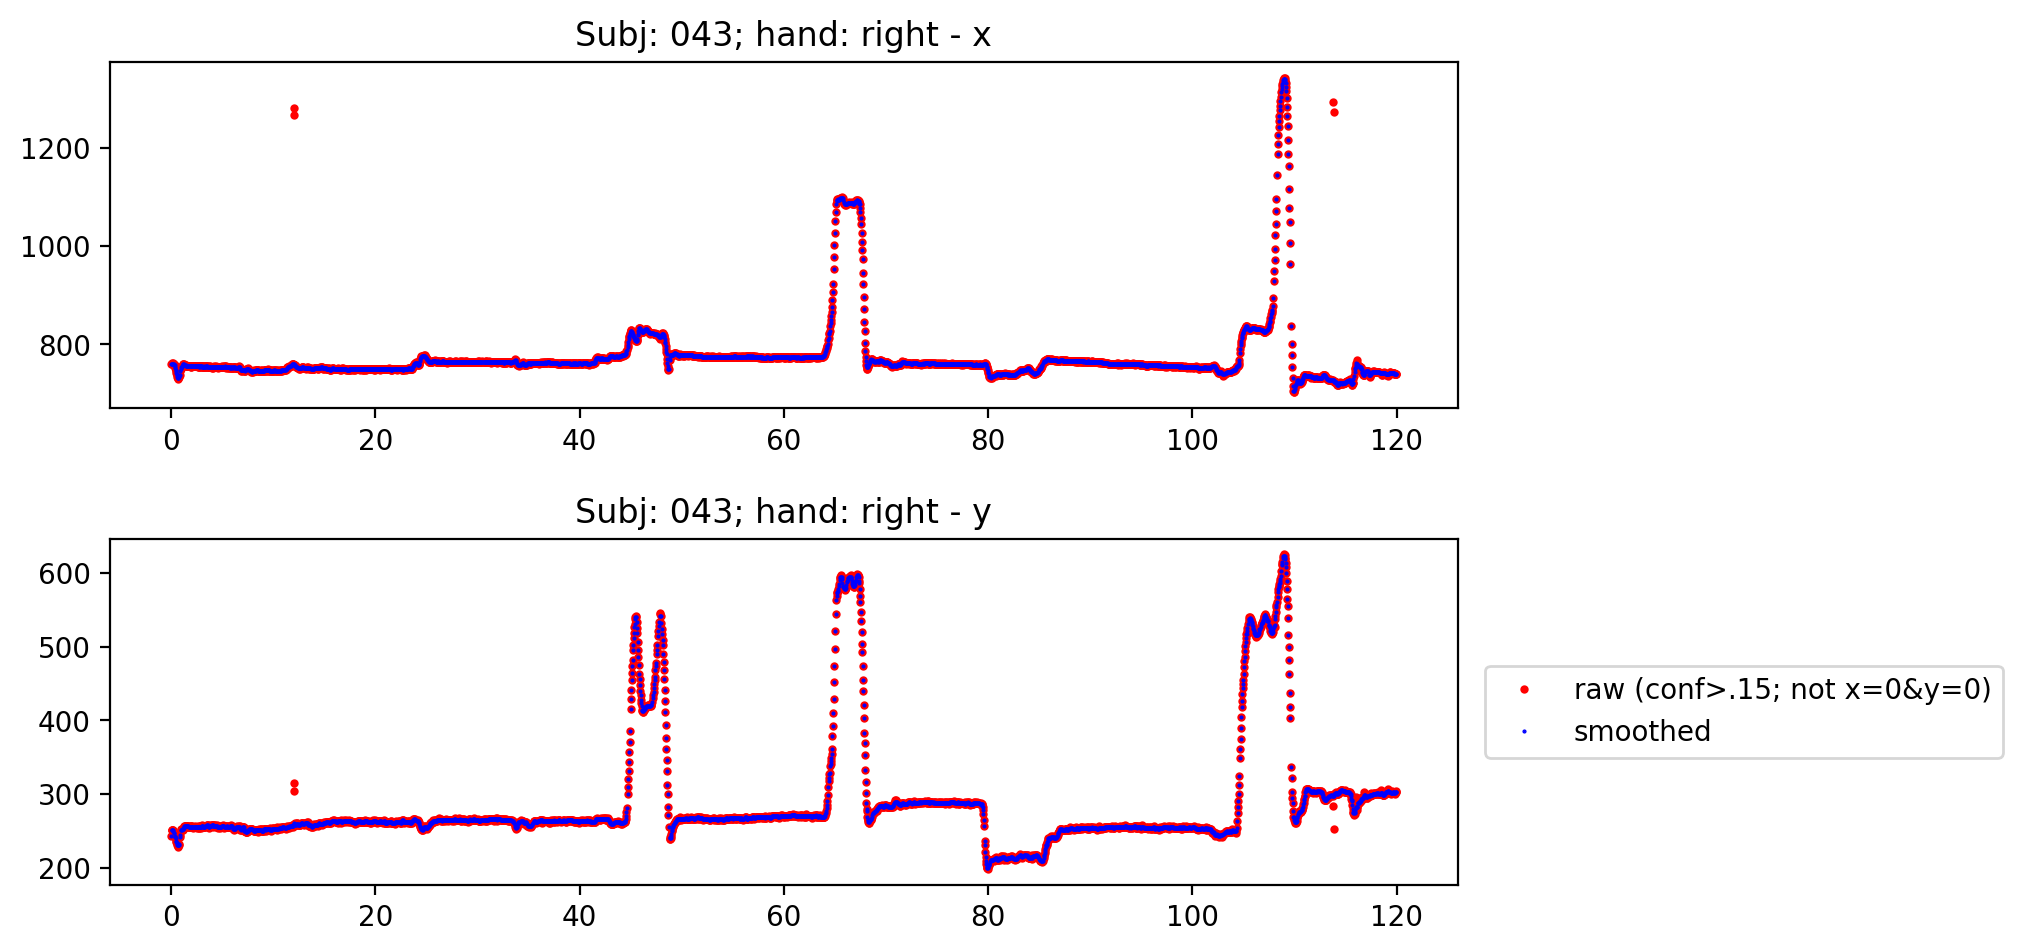

In [102]:
for subj in ('028', '043'):
    for hand in ('left', 'right'):
        file_name=f'/home/mjsobrep/Downloads/data/{subj}/target-touch/full_data-novid.hdf5'
        cam='upper'
        data = h5py.File(file_name, 'r')
        # if confidence is less than .15, just skip
        time = data[f'vid/{cam}/color/time'] - data[f'vid/{cam}/color/time'][0]
        Zs=np.ma.array(data[f'vid/{cam}/pose/mp-hands/{hand}/keypoints/color'][:,0,0:2])
        conf=data[f'vid/{cam}/pose/mp-hands/{hand}/confidence'][:]
        valid = np.any(Zs!=0, axis=1) + conf>.15
        Zs[np.logical_not(valid)]=np.ma.masked
        xs=Zs.copy()
        xs[~Zs.mask[:,0],:] = np.ma.array(signal.medfilt(Zs[~Zs.mask[:,0],:], kernel_size=[5,1]))
        xs.mask = Zs.mask
        plot_filter_out(time, Zs, xs, f'Subj: {subj}; hand: {hand}')

## Simon Says

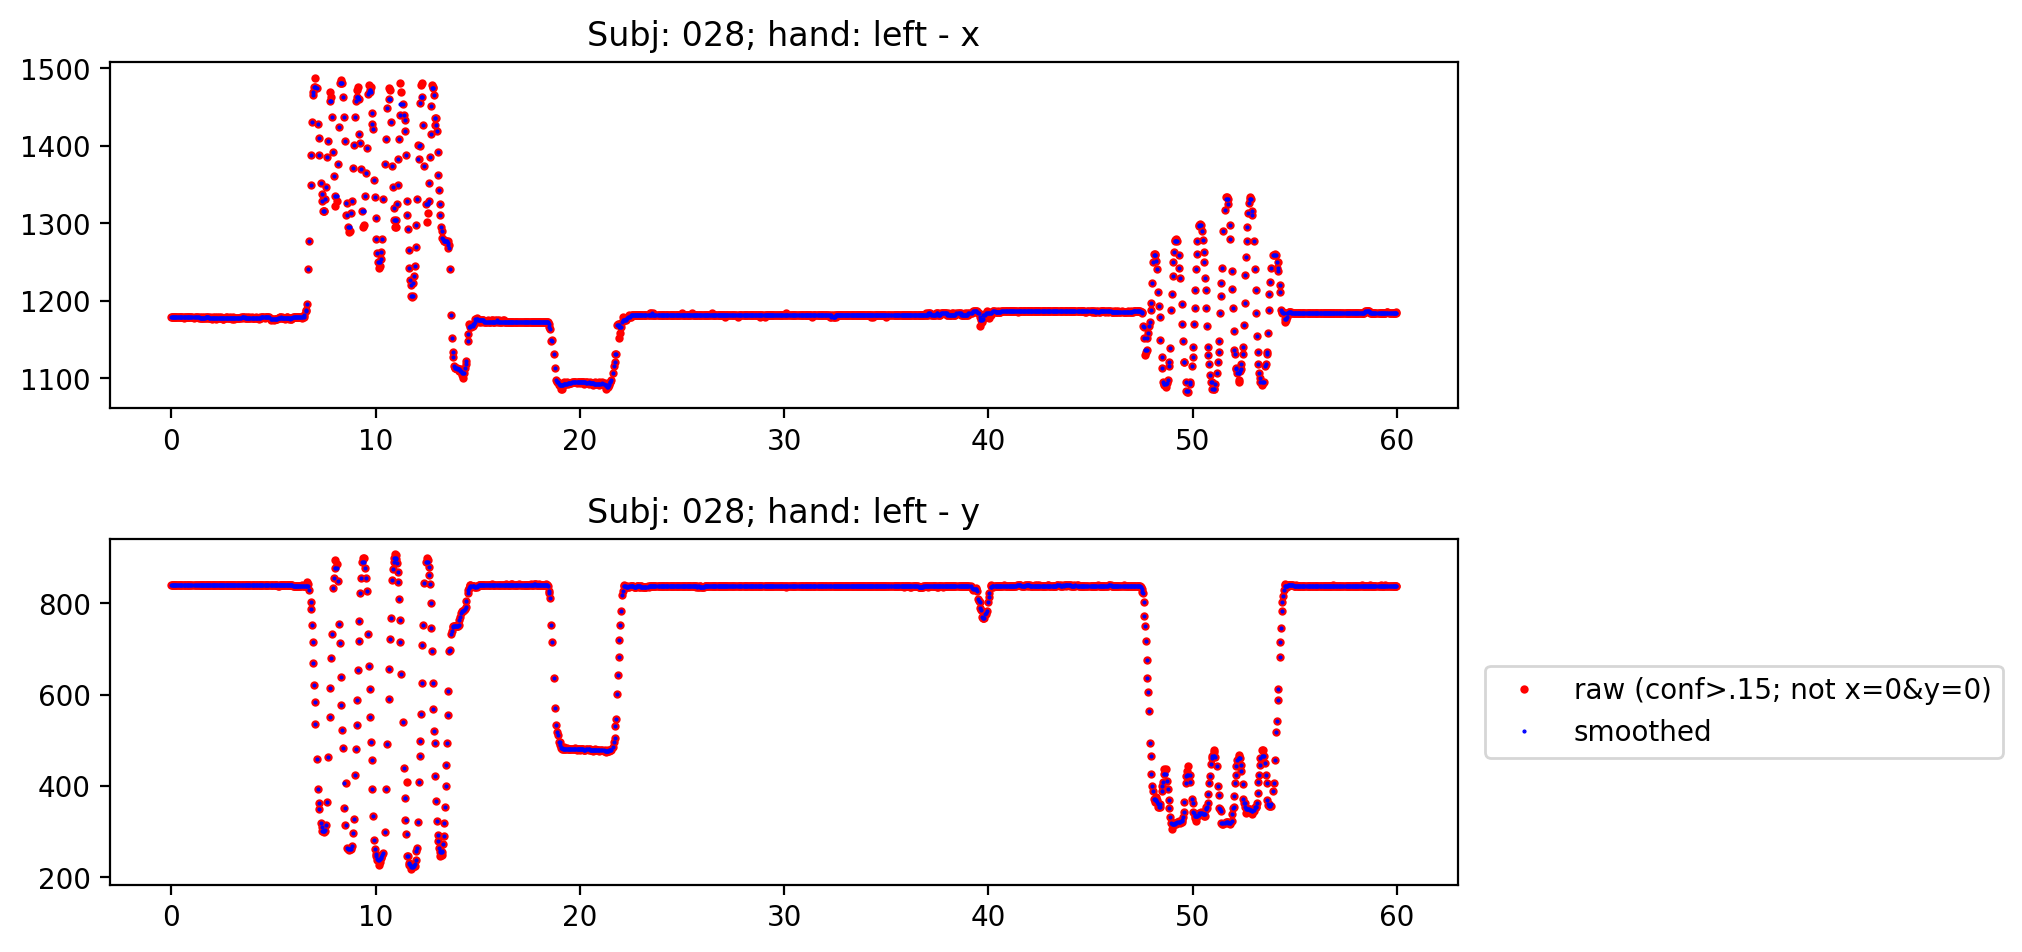

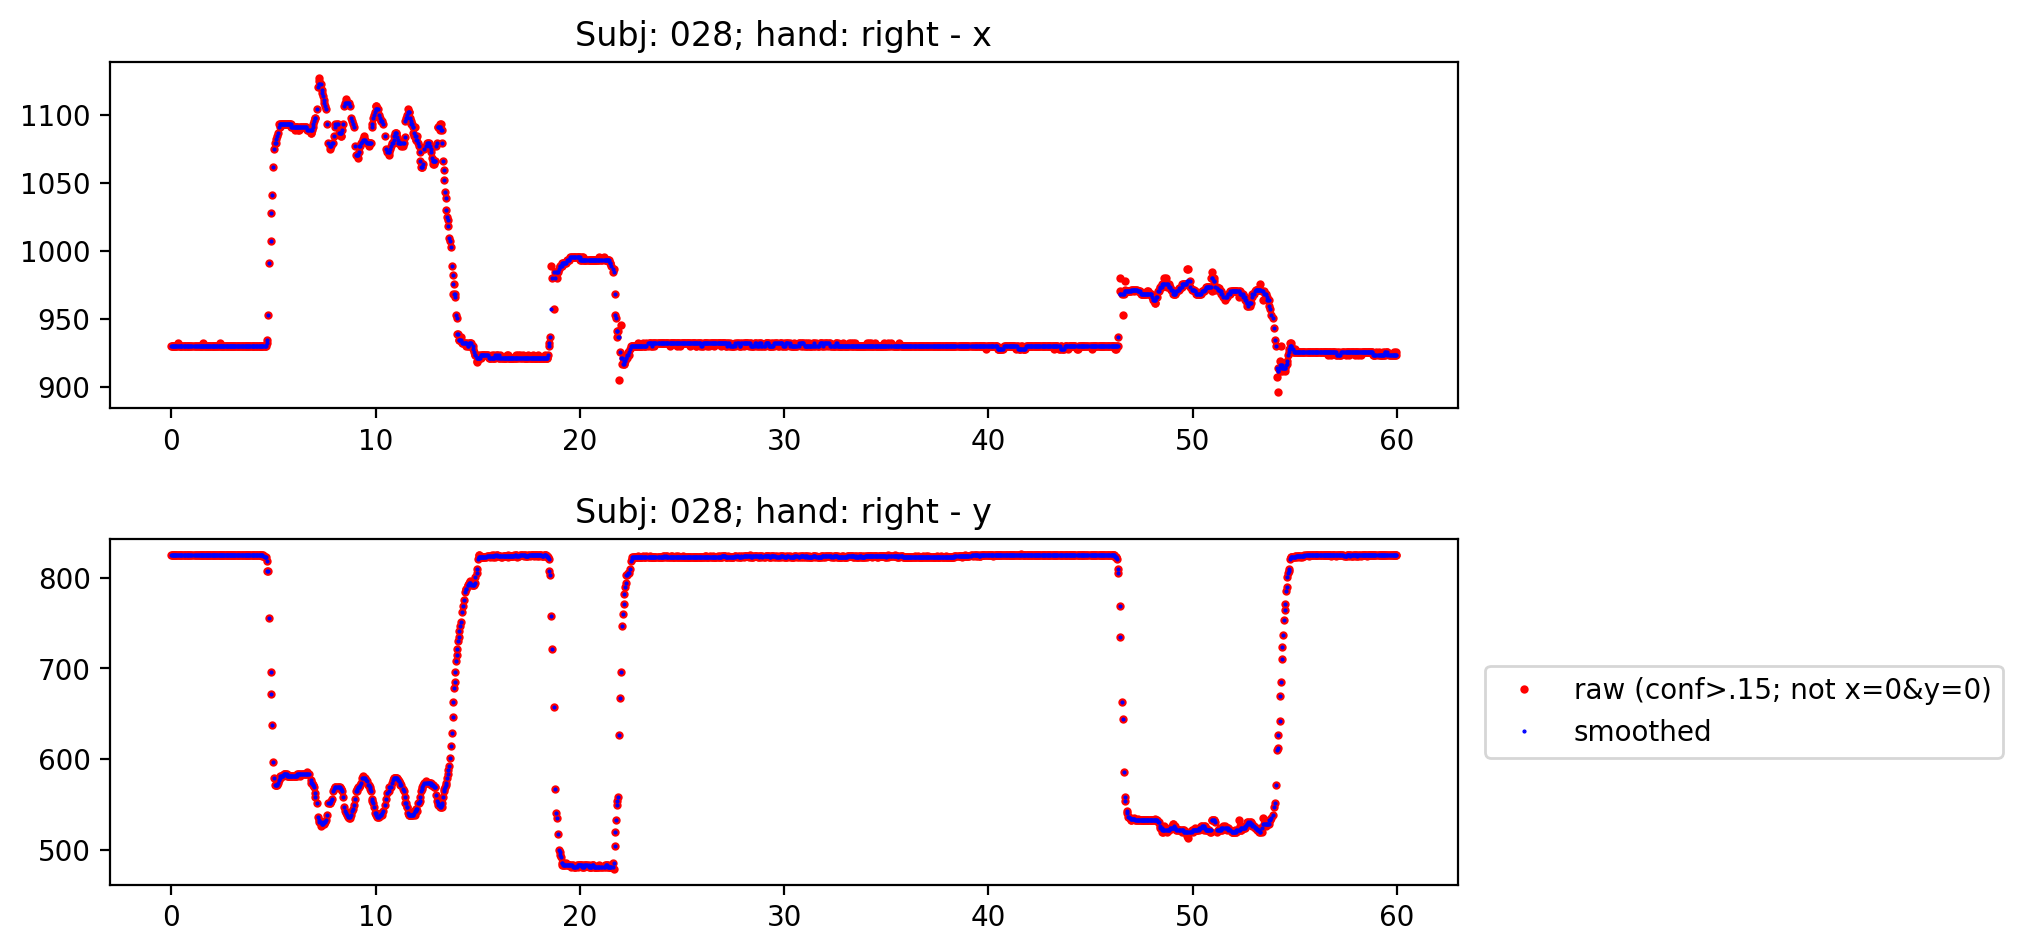

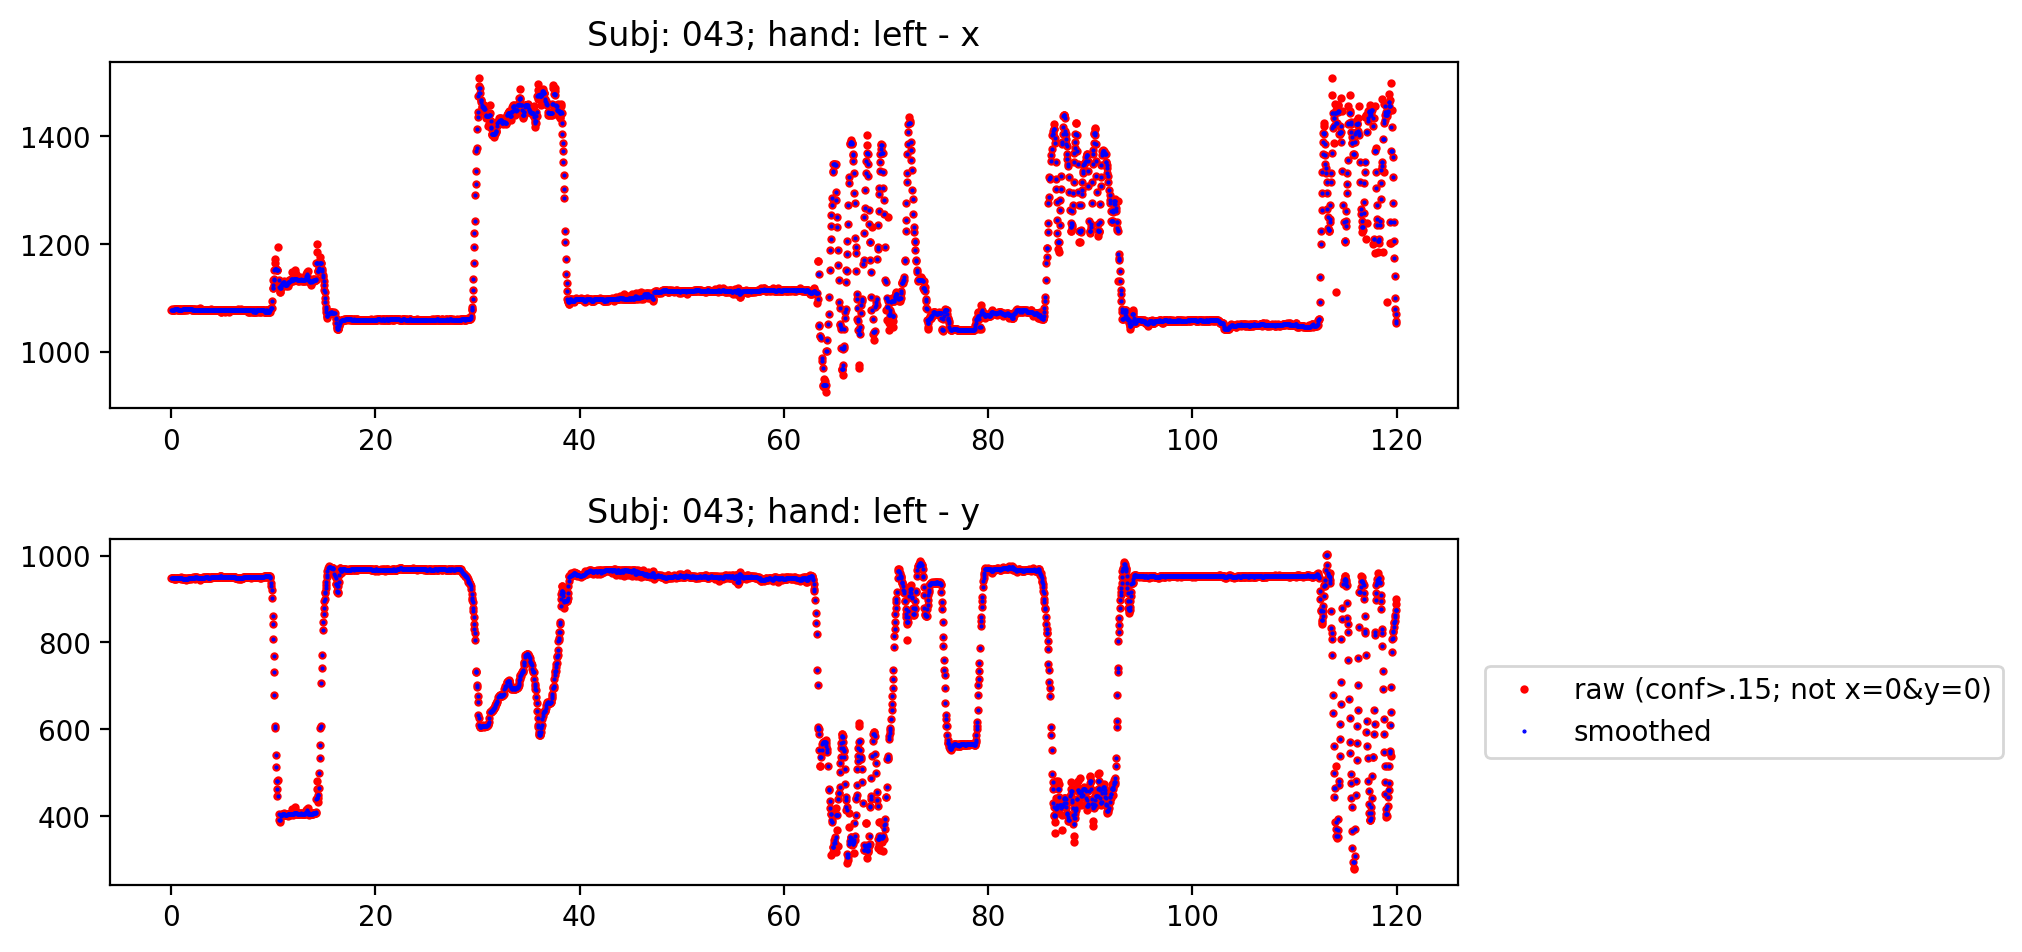

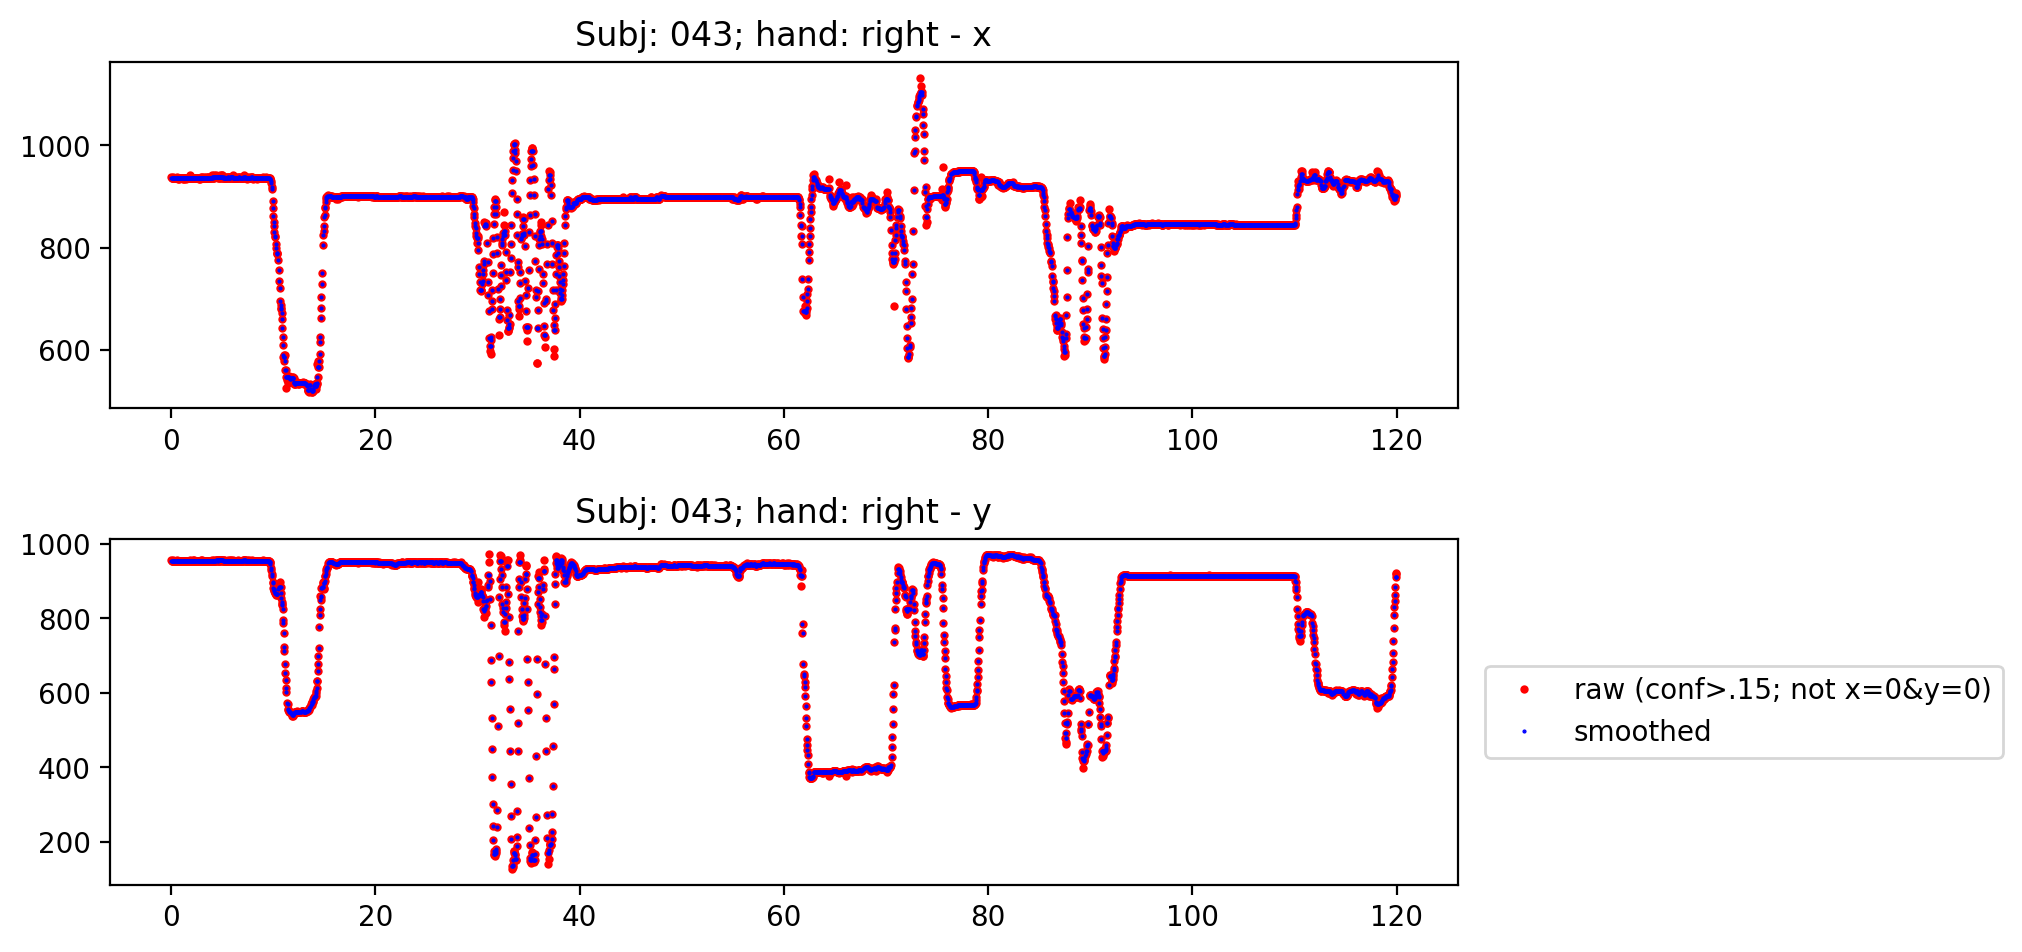

In [103]:
for subj in ('028', '043'):
    for hand, hand_idx in zip(('left', 'right'), (9,10)):
        file_name=f'/home/mjsobrep/Downloads/data/{subj}/simon-says/full_data-novid.hdf5'
        cam='lower'
        data = h5py.File(file_name, 'r')
        # if confidence is less than .15, just skip
        time = data[f'vid/{cam}/color/time'] - data[f'vid/{cam}/color/time'][0]
        Zs=np.ma.array(data[f'vid/{cam}/pose/openpose:25B/keypoints/color'][:,hand_idx,:])
        conf=data[f'vid/{cam}/pose/openpose:25B/confidence'][:, hand_idx]
        valid = np.any(Zs!=0, axis=1) + conf>.15
        Zs[np.logical_not(valid)]=np.ma.masked
        xs=Zs.copy()
        xs[~Zs.mask[:,0],:] = np.ma.array(signal.medfilt(Zs[~Zs.mask[:,0],:], kernel_size=[5,1]))
        xs.mask = Zs.mask
        plot_filter_out(time, Zs, xs, f'Subj: {subj}; hand: {hand}')